# Sample training

First notebook of the repository.
Begin by importing the learning library and a defining a convenient plotting function

In [1]:
import sys
sys.path.append('src/')
from learning import *



def plot_state_circuit(l_circuit):
    fig, axs = plt.subplots(2,3, figsize=(9,6))
    axs[0,0].plot(l_circuit.checkpoint_iterations,l_circuit.loss_history, 'o-')
    axs[0,0].set_xlabel('Iteration')
    axs[0,0].set_ylabel('Loss')
    # logscale
    axs[0,0].set_yscale('log')
    # axs.set_xscale('log')

    axs[0,1].plot(l_circuit.checkpoint_iterations,l_circuit.power_history, 'o-')
    axs[0,1].set_xlabel('Iteration')
    axs[0,1].set_ylabel('Power')

    axs[0,2].plot(l_circuit.checkpoint_iterations,l_circuit.energy_history, 'o-')
    axs[0,2].set_xlabel('Iteration')
    axs[0,2].set_ylabel('Energy')

    source_target_array = np.ones(l_circuit.n)*0.5
    source_target_array[l_circuit.indices_inputs] = 1
    source_target_array[l_circuit.indices_outputs] = 0
    l_circuit.edge_state_to_ax(axs[1,0],np.ones(l_circuit.ne),vmin = 0, vmax = 1, lw = 3, cmap='Grays')
    l_circuit.node_state_to_ax(axs[1,0], np.ones(l_circuit.n)*0.2,vmin = 0, vmax = 1, radius = 10, cmap = 'Grays', annotate = True)
    l_circuit.node_state_to_ax(axs[1,0], source_target_array, vmin = 0, vmax = 1, radius = 10, cmap = 'coolwarm')
    axs[1,0].set_title('Input/Output')

    scalarmappable = l_circuit.edge_state_to_ax(axs[1,1],l_circuit.conductances, vmin = 1e-6, vmax = 2, lw = 3, cmap=cmocean.cm.matter,autoscale=True, color_scale='log')
    fig.colorbar(scalarmappable, ax=axs[1,1], orientation='horizontal',  shrink=0.8, label='Conductance')

    input_vector = l_circuit.circuit_input(train_data[0][0][0], l_circuit.indices_inputs, l_circuit.current_bool)
    free_state = l_circuit.solve(l_circuit.Q_inputs, input_vector)
    scalarmappable = l_circuit.node_state_to_ax(axs[1,2],free_state, vmin = 0, vmax = 1, radius = 5,cmap='coolwarm',autoscale=True, color_scale='linear',plot_mode = 'voronoi')
    l_circuit.edge_state_to_ax(axs[1,2],np.ones(l_circuit.ne),vmin = 0, vmax = 1, lw = 1, cmap='Grays')
    # set the same ranges as in the previous plot
    axs[1,2].set_xlim(axs[1,0].get_xlim())
    axs[1,2].set_ylim(axs[1,0].get_ylim())
    fig.colorbar(scalarmappable, ax=axs[1,2], orientation='horizontal',  shrink=0.8, label='Voltage')

    [ax.axis('off') for ax in axs[1].flatten()]
    [ax.set_aspect('equal') for ax in axs[1].flatten()]
    plt.tight_layout()


    plt.show()

Define the graph object with networkx or any custom function. Here we use a grid.

In [2]:
n = 10
g = grid_network(n, n, periodic=False, size_uc = (1,1))

Define the learning circuit from the graph. Set option JAX to True if training with GD, False if CL.

In [3]:
initial_conductances = np.ones(g.number_of_edges())
l_circuit = learning(g, initial_conductances, jax=False)

Define some training data.
In this example we are going to define a voltage node allostery task, from two inputs to three outputs.
We begin by creating the data set.

In [4]:
n_inputs = 2
n_outputs = 3

# random input and output nodes in the network
np.random.seed(10)
indices_inputs = np.random.choice(range(g.number_of_nodes()), n_inputs + n_outputs, replace=False)
indices_outputs = indices_inputs[:n_outputs]
indices_inputs = indices_inputs[n_outputs:]
current_bool = np.array([False for i in range(n_inputs)]) # all the input nodes are voltage nodes
_ = l_circuit.set_inputs(indices_inputs, current_bool)
_ = l_circuit.set_outputs(indices_outputs)


n_data = 1
input_data = np.array([[0,1]])
input_data[:,0] = 0 # low ground
output_data = np.random.uniform(0,np.max(input_data),(n_data, len(indices_outputs)))

We then train using coupled learning

In [5]:
batch_size = 1
train_data = split_data_into_batches(input_data, output_data, batch_size)
learning_rate = 0.1
eta = 0.1
n_epochs = 1000

_ = l_circuit.train_CL(learning_rate,
                eta,
                train_data,
                n_epochs,
                save_every = 100)

Epoch: 4/1000 | Loss: 6.83e-02:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 999/1000 | Loss: 3.63e-03: 100%|██████████| 1000/1000 [00:01<00:00, 592.43it/s]


Several plots to monitor the performance of the circuit

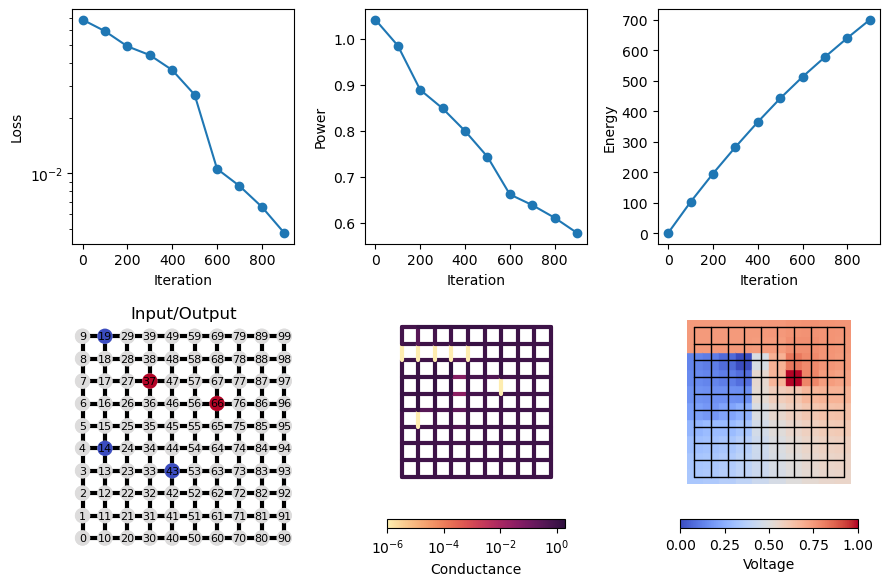

In [6]:
plot_state_circuit(l_circuit)

We can reset the training and erase the loss, power, and energy history, while preserving the conductance values as well as the input and output nodes and edges.

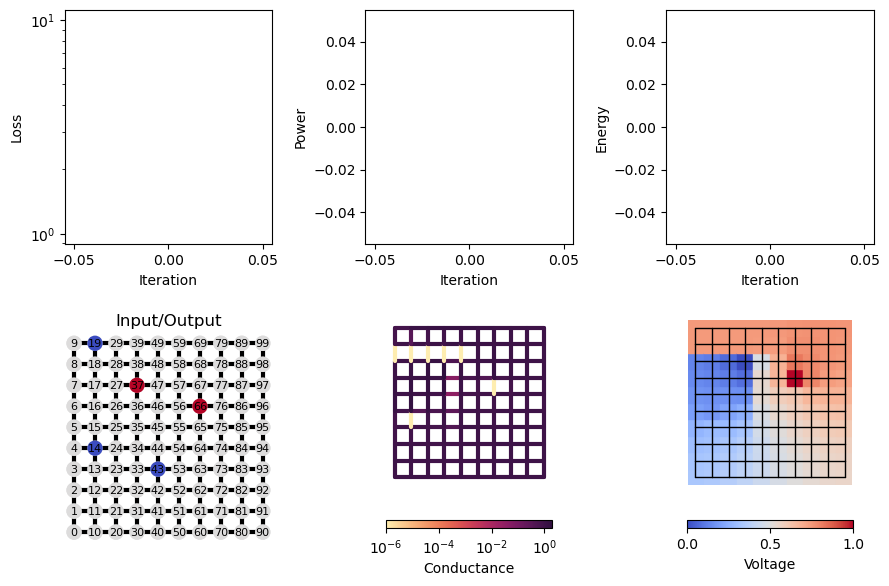

In [7]:
l_circuit.reset_training()
plot_state_circuit(l_circuit)

This time the training can be done while saving information

In [8]:
batch_size = 1
train_data = split_data_into_batches(input_data, output_data, batch_size)
learning_rate = 0.1
eta = 0.1
n_epochs = 1000

_ = l_circuit.train_CL(learning_rate,
                eta,
                train_data,
                n_epochs,
                save_every = 100,
                save_global = True,
                save_state = True, 
                save_path = 'trained_circuit')

Epoch: 999/1000 | Loss: 1.44e-03: 100%|██████████| 1000/1000 [00:01<00:00, 598.39it/s]


Data successfully saved to JSON.


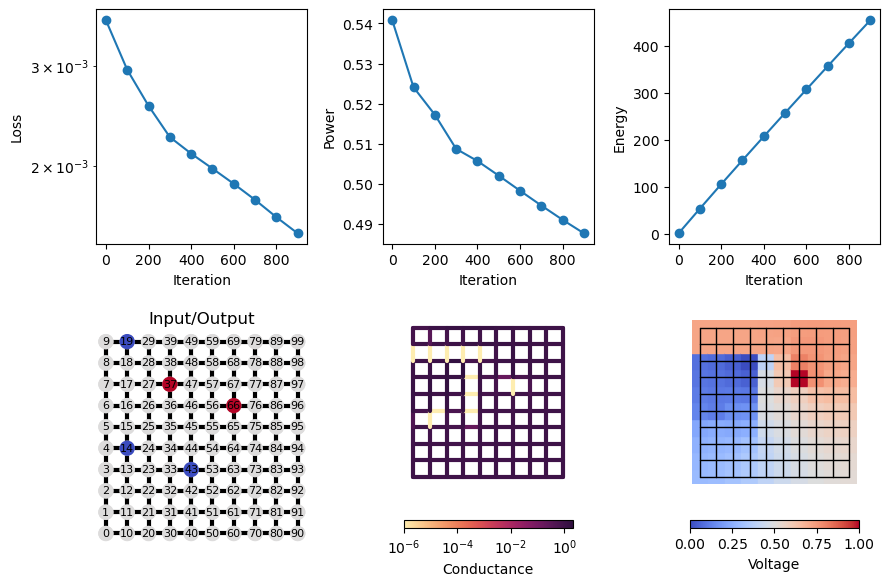

In [9]:
plot_state_circuit(l_circuit)

We can read the information and define a new learning circuit

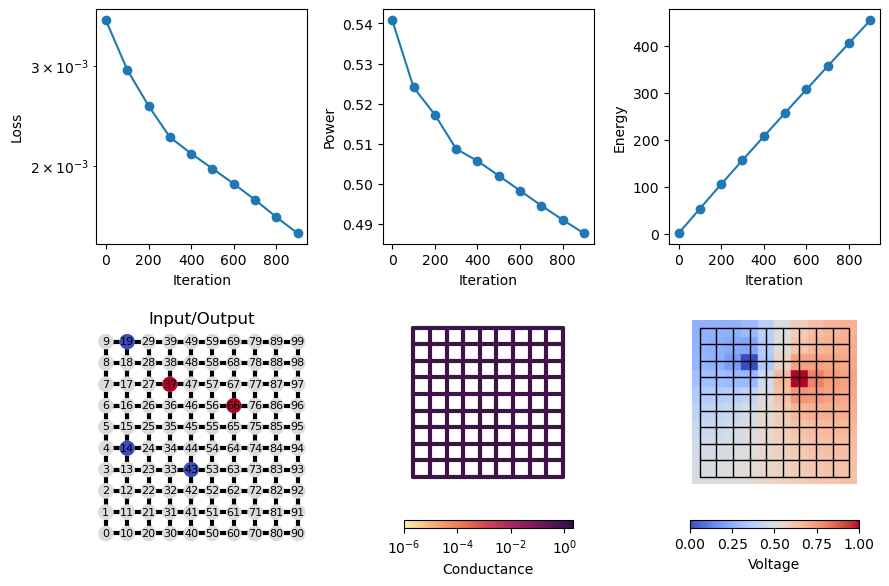

In [10]:
global_file = 'trained_circuit_global.json'
graph_file = 'trained_circuit_graph.json'
conductance_file = 'trained_circuit_conductances.csv'
l_circuit_2 = create_cl_from_json(global_file, graph_file, csv_local=None, new_train=False)

plot_state_circuit(l_circuit_2)

you can add the conductance file information to recover the last state

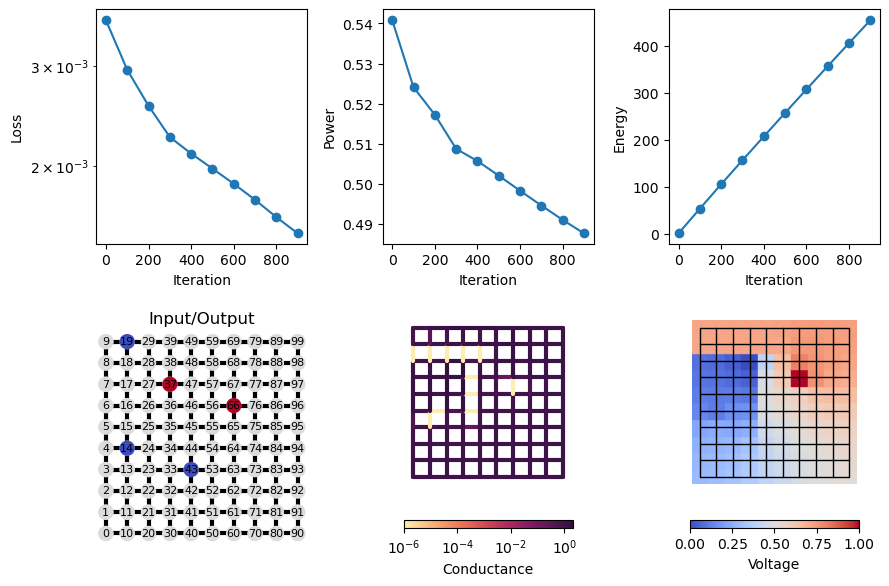

In [11]:
global_file = 'trained_circuit_global.json'
graph_file = 'trained_circuit_graph.json'
conductance_file = 'trained_circuit_conductances.csv'
l_circuit_2 = create_cl_from_json(global_file, graph_file, csv_local=conductance_file, new_train=False)

plot_state_circuit(l_circuit_2)

Now we can continue the training

In [12]:
batch_size = 1
train_data = split_data_into_batches(input_data, output_data, batch_size)
learning_rate = 0.1
eta = 0.1
n_epochs = 1000

_ = l_circuit_2.train_CL(learning_rate,
                eta,
                train_data,
                n_epochs,
                save_every = 100,
                save_global = False,
                save_state = False, 
                save_path = 'trained_circuit')

Epoch: 999/1000 | Loss: 6.34e-04: 100%|██████████| 1000/1000 [00:01<00:00, 605.81it/s]


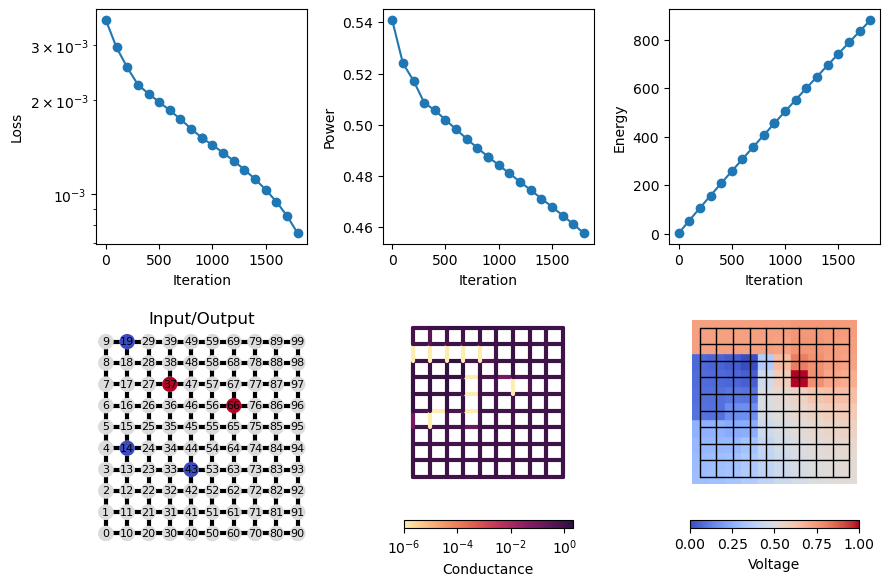

In [13]:
plot_state_circuit(l_circuit_2)

You can conver the circuit to JAX to train with gradient descent instead

Converted to jax


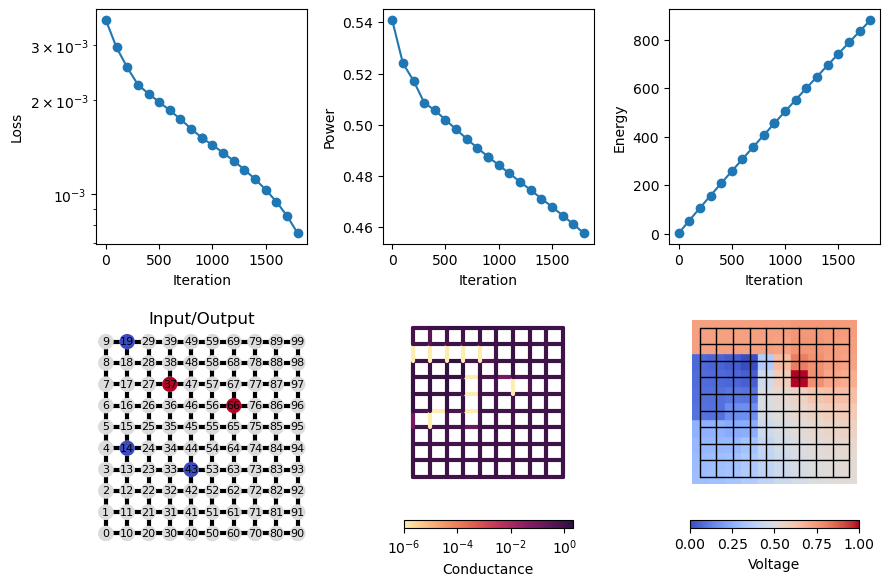

In [14]:
l_circuit_2.jaxify()

plot_state_circuit(l_circuit_2)

In [15]:
batch_size = 1
train_data = split_data_into_batches(input_data, output_data, batch_size)
learning_rate = 0.1
# eta = 0.1
n_epochs = 1000

_ = l_circuit_2.train_GD(learning_rate,
                train_data,
                n_epochs,
                save_every = 100,
                save_global = False,
                save_state = False, 
                save_path = 'trained_circuit')

Epoch: 999/1000 | Loss: 3.57e-04: 100%|██████████| 1000/1000 [00:04<00:00, 225.45it/s]


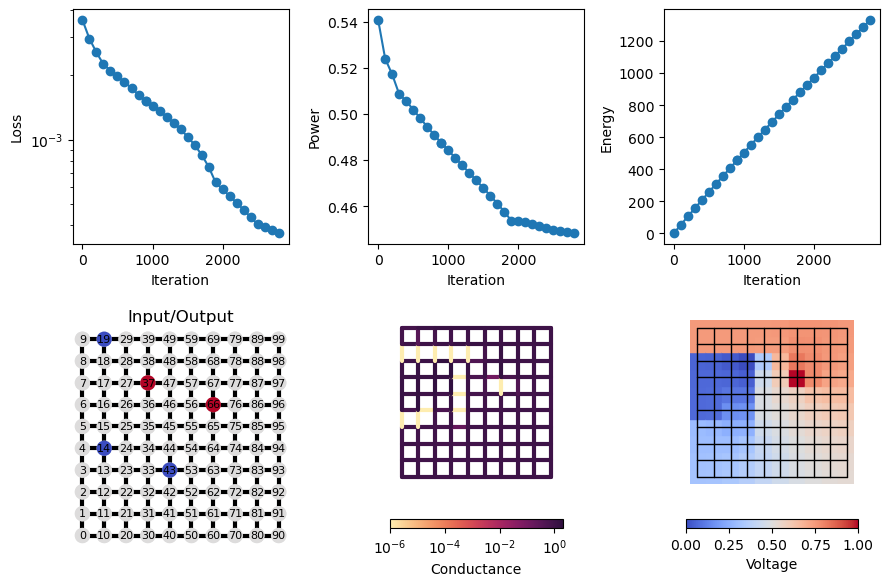

In [16]:
plot_state_circuit(l_circuit_2)

As a last example, let's train a jammed network for classification, using currents as inputs and training with Gradient Descent.
We follow the same previous steps and we create the dataset

In [36]:
n = 100
g = jammed_network(n, seed = 1)
initial_conductances = np.ones(g.number_of_edges())
l_circuit_3 = learning(g, initial_conductances, jax=True)

indices_inputs = np.array([59,42,60,31,29,35]) # features and 1, negative features and -1
indices_outputs = np.array([1,12,19])
n_inputs = len(indices_inputs)
n_outputs = len(indices_outputs)

current_bool = np.array([True for i in range(n_inputs)]) # current inputs
current_bool[2] = False
current_bool[5] = False

_ = l_circuit_3.set_inputs(indices_inputs, current_bool)
_ = l_circuit_3.set_outputs(indices_outputs)



progress: 100%|##########| 1000.00/1000.00 [00:01<00:00]


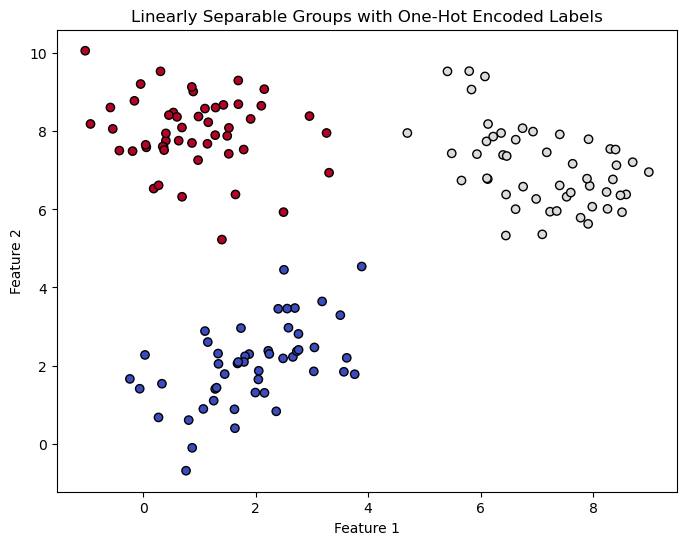

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
# Re-generate a similar dataset with two linearly separable groups
np.random.seed(0)  # For reproducibility

# Group 1
n1 = 50
mean1 = [2, 2]
cov1 = [[1, 0.5], [0.5, 1]]
group1 = np.random.multivariate_normal(mean1, cov1, n1)

# Group 2
n2 = 50
mean2 = [7, 7]
cov2 = [[1, -0.5], [-0.5, 1]]
group2 = np.random.multivariate_normal(mean2, cov2, n2)

# Group 3
n3 = 50
mean3 = [1, 8]
cov3 = [[1, 0], [0, 1]]
group3 = np.random.multivariate_normal(mean3, cov3, n3)

# Combine into a single dataset
data = np.vstack((group1, group2, group3))
labels = np.array([[1, 0, 0]]*n1 + [[0, 1, 0]]*n2 + [[0, 0, 1]]*n3)  # One-hot encoding

# Create a DataFrame for the data
df_data = pd.DataFrame(data, columns=['Feature_1', 'Feature_2'])
df_labels = pd.DataFrame(labels, columns=['Label_0', 'Label_1', 'Label_2'])


# n_data = 100
# input_data = np.random.uniform(0,1,(n_data, len(indices_inputs)))
# input_data[:,0] = 0 # low ground
# matrix = np.random.uniform(0,1,(len(indices_outputs), len(indices_inputs)))
# # output_data = np.random.uniform(0,np.max(input_data),(n_data, len(indices_outputs)))
# output_data = input_data.dot(matrix.T)


X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.2, random_state=42)

input_data = np.concatenate((X_train.to_numpy(),np.ones((X_train.shape[0],1))),axis=1)
input_data = np.concatenate((input_data,-input_data),axis=1)
output_data = y_train.to_numpy()

# Plotting the dataset with one-hot encoded labels
plt.figure(figsize=(8, 6))
# Use the first column of the one-hot encoded labels to determine the color
plt.scatter(data[:, 0], data[:, 1], c=np.argmax(labels,axis=1), cmap='coolwarm', edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linearly Separable Groups with One-Hot Encoded Labels')
plt.show()

In [38]:
batch_size = 30
train_data = split_data_into_batches(input_data, output_data, batch_size)
n_epochs = 1000

_, _ ,_,_ = l_circuit_3.train_GD(learning_rate,
                train_data,
                n_epochs,
                save_every = 1)

Epoch: 999/1000 | Loss: 9.40e-02: 100%|██████████| 1000/1000 [00:59<00:00, 16.71it/s]


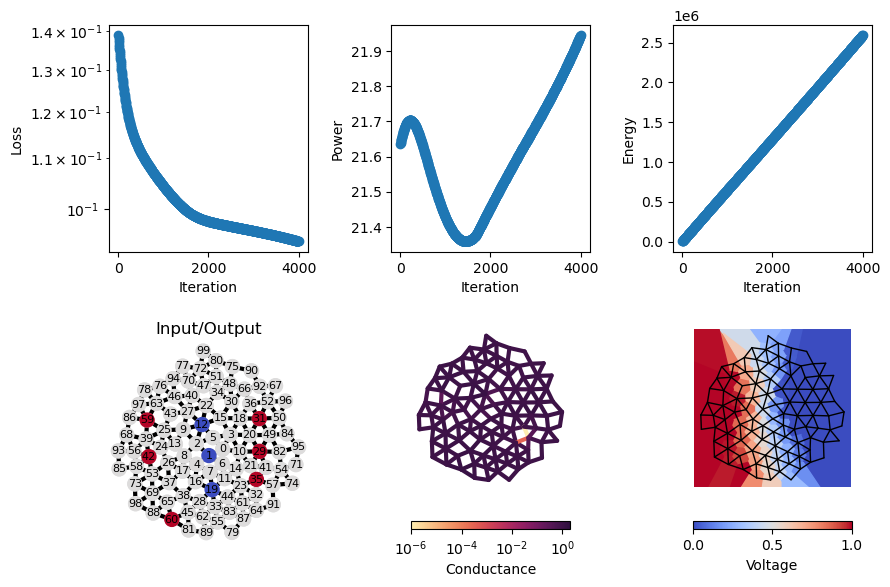

In [39]:
plot_state_circuit(l_circuit_3)

Accuracy: 0.4000


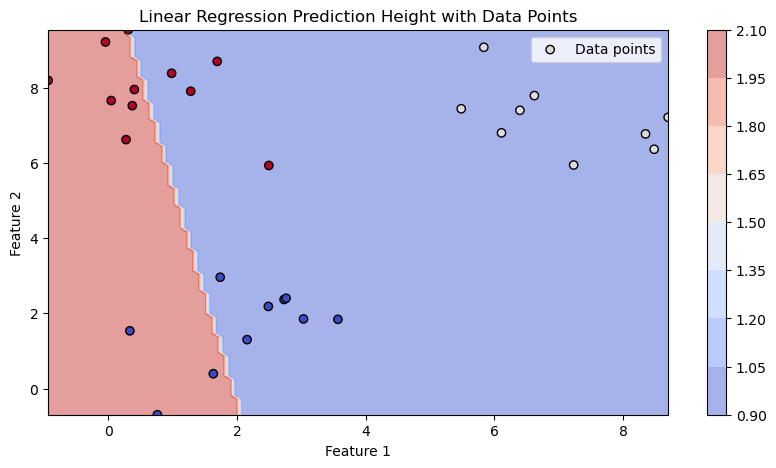

In [42]:
input_data = train_data[0][0]
target_data = train_data[0][1]
output_data_free = np.array([l_circuit_3.Q_outputs.T.dot(l_circuit_3.solve(l_circuit_3.Q_inputs, l_circuit_3.circuit_input(inp, l_circuit_3.indices_inputs, l_circuit_3.current_bool))) for inp in input_data])

y_pred_labels = np.argmax(output_data_free, axis=1)

# If you want to compare with the original class labels, you need to convert y_test from one-hot encoding as well
y_test_labels = np.argmax(target_data, axis=1)

# You can calculate the accuracy manually or use a utility function
accuracy = np.mean(y_pred_labels == y_test_labels)
print(f'Accuracy: {accuracy:.4f}')

# Create a mesh grid covering the feature space
x1_range = np.linspace(X_test['Feature_1'].min(), X_test['Feature_1'].max(), 100)
x2_range = np.linspace(X_test['Feature_2'].min(), X_test['Feature_2'].max(), 100)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

# Predict using the linear regression model for each point in the mesh grid
input_data = np.concatenate((x1_grid.ravel().reshape(-1,1),x2_grid.ravel().reshape(-1,1),np.ones((x1_grid.ravel().shape[0],1))),axis=1)
input_data = np.concatenate((input_data,-input_data),axis=1)
y_grid_pred = np.array([l_circuit_3.Q_outputs.T.dot(l_circuit_3.solve(l_circuit_3.Q_inputs, l_circuit_3.circuit_input(inp, l_circuit_3.indices_inputs, l_circuit_3.current_bool))) for inp in input_data])
y_grid_pred_1 = y_grid_pred[:,0].reshape(x1_grid.shape)
y_grid_pred_2 = y_grid_pred[:,1].reshape(x1_grid.shape)
y_grid_pred_3 = y_grid_pred[:,2].reshape(x1_grid.shape)


fig, axs = plt.subplots(1,1,figsize=(10, 5))
contour = axs.contourf(x1_grid, x2_grid, np.argmax(y_grid_pred,axis=1).reshape(x1_grid.shape), cmap='coolwarm', alpha=0.5)
axs.scatter(X_test['Feature_1'], X_test['Feature_2'], c=np.argmax(y_test,axis=1), cmap='coolwarm', edgecolor='k', label='Data points')
fig.colorbar(contour, ax=axs)
axs.set_xlabel('Feature 1')
axs.set_ylabel('Feature 2')
axs.set_title('Linear Regression Prediction Height with Data Points')
axs.legend()
plt.show()